<a href="https://colab.research.google.com/github/Amitparikh1/NFL-ML-Predictor/blob/master/NFL_ML_Score_Predictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install sportsreference
!pip install scikit-learn

     |████████████████████████████████| 481kB 2.7MB/s 


Imports

In [ ]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import sportsreference.nfl
from sportsreference.nfl.teams import Teams
from sportsreference.nfl.schedule import Schedule
from sportsreference.nfl.boxscore import Boxscore
from sklearn.linear_model import LinearRegression,Ridge

Get Data

In [ ]:
## Initialize Data Frame
columns = ["Team","Week","AvgPointsScored","AvgPassYards","AvgRushYards","AvgInterceptions","AvgTimesSacked","OppPointsAllowed","OppPassYards","OppRushYards","OppInterceptions","OppSacks","Points"]

df = pd.DataFrame(columns=columns)

teams = Teams()
counter = 0
predictionWeek = 5 ##THIS VARIABLE IS THE WEEK TO PREDICT FOR
## Loop through each team
for team in teams:
  schedule = Schedule(team.abbreviation)
  ## Variables to store total data about the offense
  totPointsScored = 0
  totPassYards = 0
  totRushYards = 0
  totInterceptions = 0
  totTimesSacked = 0
  team = team.abbreviation
  ## Loop through each week 
  for game in schedule:
    if (game.week<=predictionWeek):
      opposing_schedule = Schedule(game.opponent_abbr)
      # Keep track of the opposing teams totals
      opp_points_allowed = 0
      opp_pass_yards = 0
      opp_rush_yards = 0
      opp_interceptions = 0
      opp_sacks = 0
      for opp_game in opposing_schedule:
        opp_boxscore = Boxscore(opp_game.boxscore_index)
        if (opp_game.week < game.week):
          if (game.opponent_abbr == opp_boxscore.winning_abbr):
            if (opp_boxscore.winner == "Home"):
              opp_points_allowed += opp_boxscore.away_points
              opp_pass_yards += opp_boxscore.away_net_pass_yards
              opp_rush_yards += opp_boxscore.away_rush_yards
              opp_interceptions += opp_boxscore.away_interceptions
              opp_sacks += opp_boxscore.away_times_sacked
            else:
              opp_points_allowed += opp_boxscore.home_points
              opp_pass_yards += opp_boxscore.home_net_pass_yards
              opp_rush_yards += opp_boxscore.home_rush_yards
              opp_interceptions += opp_boxscore.home_interceptions
              opp_sacks += opp_boxscore.home_times_sacked
          else:
            if (opp_boxscore.winner == "Home"):
              opp_points_allowed += opp_boxscore.home_points
              opp_pass_yards += opp_boxscore.home_net_pass_yards
              opp_rush_yards += opp_boxscore.home_rush_yards
              opp_interceptions += opp_boxscore.home_interceptions
              opp_sacks += opp_boxscore.home_times_sacked
            else:
              opp_points_allowed += opp_boxscore.away_points
              opp_pass_yards += opp_boxscore.away_net_pass_yards
              opp_rush_yards += opp_boxscore.away_rush_yards
              opp_interceptions += opp_boxscore.away_interceptions
              opp_sacks += opp_boxscore.away_times_sacked
          
      
      if (game.week == 1):
        totPointsScored += game.points_scored
        totPassYards += game.pass_yards
        totRushYards += game.rush_yards
        totInterceptions += game.interceptions
        totTimesSacked += game.times_sacked
        
      else:
        weekToDivide = game.week - 1
        
        if (game.week is not predictionWeek):
          df.loc[counter]={"Team":team,"Week":game.week,"AvgPointsScored":totPointsScored/weekToDivide,"AvgPassYards":totPassYards/weekToDivide,"AvgRushYards":totRushYards/weekToDivide,"AvgInterceptions":totInterceptions/weekToDivide,"AvgTimesSacked":totTimesSacked/weekToDivide,"OppPointsAllowed":(opp_points_allowed/weekToDivide),"OppPassYards":(opp_pass_yards/weekToDivide),"OppRushYards":(opp_rush_yards/weekToDivide),"OppInterceptions":(opp_interceptions/weekToDivide),"OppSacks":(opp_sacks/weekToDivide),"Points":game.points_scored}
          totPointsScored += game.points_scored
          totPassYards += game.pass_yards
          totRushYards += game.rush_yards
          totInterceptions += game.interceptions
          totTimesSacked += game.times_sacked
        else: ##Put "-1" in points column if the game hasn't been played yet
          df.loc[counter]={"Team":team,"Week":game.week,"AvgPointsScored":totPointsScored/weekToDivide,"AvgPassYards":totPassYards/weekToDivide,"AvgRushYards":totRushYards/weekToDivide,"AvgInterceptions":totInterceptions/weekToDivide,"AvgTimesSacked":totTimesSacked/weekToDivide,"OppPointsAllowed":(opp_points_allowed/weekToDivide),"OppPassYards":(opp_pass_yards/weekToDivide),"OppRushYards":(opp_rush_yards/weekToDivide),"OppInterceptions":(opp_interceptions/weekToDivide),"OppSacks":(opp_sacks/weekToDivide),"Points":-1}
        print(counter+1)
        counter +=1
## Save to dataframe 
df.to_csv("nfl_data.csv")  

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124


Split data up into x,y, train and test

In [ ]:
def splitData(data,week):
  train = data.loc[data['Week']<week]
  test = data.loc[data['Week']==week]
  x_train = train.iloc[:,2:12]
  y_train = train.iloc[:,12]
  x_test = test.iloc[:,2:12]
  y_test = test.iloc[:,12]
  return x_train,y_train,x_test,y_test


Regression Models

In [ ]:
def linear_regression(x_train,y_train,x_test,y_test):
  linear_regressor = LinearRegression()
  linear_regressor.fit(x_train,y_train)
  score_predictions = linear_regressor.predict(x_test)
  print("Linear:")
  print(linear_regressor.score(x_test,y_test))
  return score_predictions

## Ridge regression is used when variables may have multicollinearity which should be the case for variables such as passing yards and points scored etc.  
def ridge_regression(x_train,y_train,x_test,y_test):
  ridge_regressor = Ridge(alpha=100)
  ridge_regressor.fit(x_train,y_train)
  score_predictions = ridge_regressor.predict(x_test)
  print("Ridge:")
  print(ridge_regressor.score(x_test,y_test))
  return score_predictions


Compare Predictions to Actual Results

In [ ]:
def deviation(score_predictions,y_test):
  ## Standard Deviation
  count = 0
  std_sum = 0
  for i in range(len(score_predictions)):
    std_sum += abs(score_predictions[i]-y_test.iloc[i])
    count+=1
  return (std_sum/count)
  #print("Standard deviation of predicted scores from actual scores for week "+str(week) +" is "+str((std_sum/count)))

Run Code

In [ ]:
season_data = pd.read_csv("nfl_data.csv",index_col=None)
season_data = season_data.iloc[:,1:14]
linear_std_deviations = []
ridge_std_deviations = []
count = 0
for i in range(3,5):
  xTr,yTr,xTe,yTe = splitData(season_data,i)
  linear_predictions = linear_regression(xTr,yTr,xTe,yTe)
  ridge_predictions = ridge_regression(xTr,yTr,xTe,yTe)
  linear_std_deviations.append(deviation(linear_predictions,yTe))
  ridge_std_deviations.append(deviation(ridge_predictions,yTe))

print(linear_std_deviations)
print(ridge_std_deviations)

Linear:
0.06691744943632627
Ridge:
0.2117155567565412
Linear:
-0.17912392797172227
Ridge:
-0.1344840916741119
[6.6451691241800015, 8.154612978450144]
[6.1552452743218, 7.882148794613344]


Plots

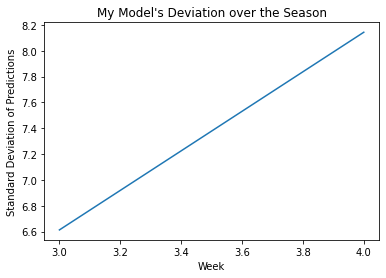

In [ ]:
## Line Graph of Standard Deviations
plt.plot(range(3,5),linear_std_deviations)
plt.xlabel("Week")
plt.ylabel("Standard Deviation of Predictions")
plt.title("My Model's Deviation over the Season")
plt.show()

Ridge:
0.2117155567565412
Ridge:
-0.1344840916741119


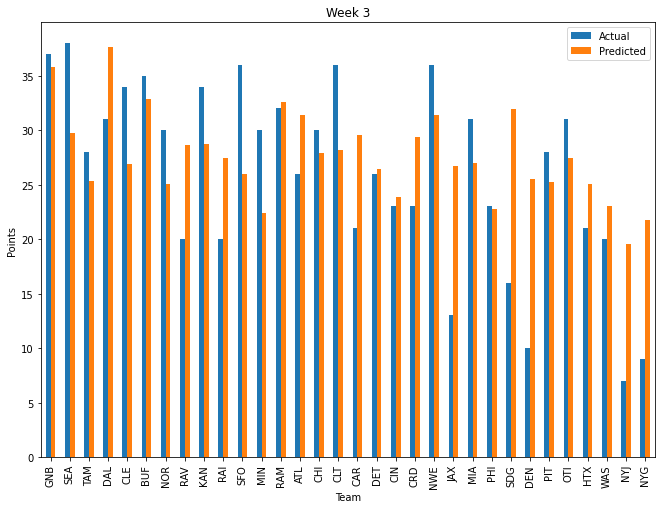

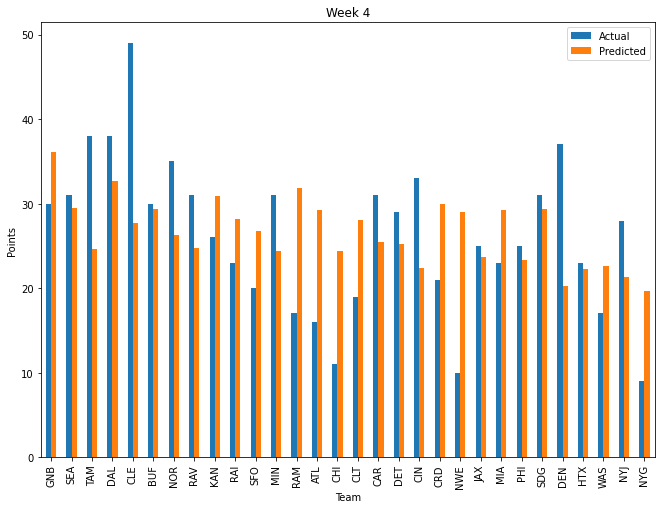

In [ ]:
##Side by side histogram of predictions and actual scores
hist_df = season_data[['Team','Week','Points']]
hist_df = hist_df.rename(columns={"Points":"Actual"})
for i in range(3,5):
  week_df = hist_df.loc[hist_df['Week']==i]
  xTr,yTr,xTe,yTe = splitData(season_data,i)
  predictions = ridge_regression(xTr,yTr,xTe,yTe)
  week_df.insert(3,"Predicted",predictions,True)
  this_week = week_df.loc[week_df['Week']==i]
  this_week.plot.bar(x='Team',y=['Actual','Predicted'])
  plt.ylabel("Points")
  plt.title("Week "+str(i))
  fig = plt.gcf()
  fig.set_size_inches(11,8)
  
